In [467]:
import numpy as np

from gbsio import read_from_csv
from partition import SSIPartitioner
from gbs import compute_unmarked_ssi, compute_marked_ssi
from gbs.ssi.utils import generate_background_points, auto_density

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from pyproj import Transformer

In [468]:
def draw_scenario(data, centeridx=8, partitioner=None, radius=0.01, type='full'):
    if not partitioner:
        partitioner = SSIPartitioner(coords, k=400)
    i = centeridx
    center = data.get('coords')[i]
    presence_ids = partitioner.get_neighborhood(i, radius)
    presence_points = data.get('coords')[presence_ids]
    presence_values = data.get('values')[presence_ids]
    density = auto_density(radius, presence_points.shape[0])
    bg_points = generate_background_points(center, radius, density=density)

    marked_ssi = compute_marked_ssi(presence_points, presence_values, center, radius, density="auto", k=4)
    avg_acc = np.mean(np.where(presence_values<0, 0, presence_values))

    gdf_bg = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in np.degrees(bg_points)], crs="EPSG:4326")
    gdf_presence = gpd.GeoDataFrame(zip(presence_ids, presence_values), columns=['id', 'value'], geometry=[Point(lon, lat) for lat, lon in np.degrees(presence_points)], crs="EPSG:4326")
    gdf_presence_t = gdf_presence[gdf_presence['value']>0]
    gdf_presence_f = gdf_presence[gdf_presence['value']<0]

    marker_style_presence_t = dict(color='blue', marker='o', markersize=50,alpha=0.7, label='correct')
    marker_style_presence_f = dict(color='red', marker='o', markersize=50, alpha=0.7, label='incorrect')
    bg_markersize = {'full': 100, 'single': 20}
    marker_style_bg = dict(color='tab:grey',  marker='.', markersize=bg_markersize[type], label='background')

    if type=='full':

        # Function to generate a circle from lat/lon in radians
        def create_circle(lat_rad, lon_rad, radius, num_points=100):
            """
            Creates a circle (polygon) centered at (lat_rad, lon_rad) with radius in radians.
            """
            # Convert center point to degrees
            lat_deg = np.degrees(lat_rad)
            lon_deg = np.degrees(lon_rad)

            # Create a list to store the circle's points
            circle_points = []
            
            # Generate points around the circle
            for angle in np.linspace(0, 2 * np.pi, num_points):
                # Compute the new latitude/longitude using the radius
                new_lat = np.degrees(lat_rad + radius * np.sin(angle))
                new_lon = np.degrees(lon_rad + radius * np.cos(angle))
                circle_points.append((new_lon, new_lat))  # (lon, lat) format

            # Create a polygon from the generated circle points
            return Polygon(circle_points)
        
        def calculate_line_length_km(line):
            """
            Calculate the geodesic length of a LineString in EPSG:4326 using pyproj.
            """
            transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
            
            # Transform the LineString to a projected coordinate system
            line_projected = LineString([transformer.transform(x, y) for x, y in line.coords])
            
            # Calculate length in meters and convert to km
            return round(line_projected.length / 1000)  # Convert meters to km

        # Define centerpoint in radians
        lat_rad_center, lon_rad_center = center   # Example longitude in radians (~60 degrees)

        # Generate the circle polygon
        circle_polygon = create_circle(lat_rad_center, lon_rad_center, radius)

        # Create a GeoDataFrame
        gdf_circle = gpd.GeoDataFrame(geometry=[circle_polygon], crs="EPSG:4326")

        # Create a GeoDataFrame for centerpoint
        center_point = Point(np.degrees(lon_rad_center), np.degrees(lat_rad_center))
        center_gdf = gpd.GeoDataFrame(geometry=[Point(np.degrees(lon_rad_center), np.degrees(lat_rad_center))], crs="EPSG:4326")

        # Compute the edge point
        edge_lat = np.degrees(lat_rad_center)
        edge_lon = np.degrees(lon_rad_center + radius)
        edge_point = Point(edge_lon, edge_lat)

        # Create line geometry from center to edge
        from shapely.geometry import LineString
        arrow_line = LineString([center_point, edge_point])
        line_gdf = gpd.GeoDataFrame(geometry=[arrow_line], crs="EPSG:4326")

        # Set up subplots
        fig = plt.figure(figsize=(12, 12))
        gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
        (ax1, ax2), (ax3, ax4) = gs.subplots(sharex='all', sharey='all')
        axes =  [ax1, ax2, ax3, ax4]

        # set up styles
        patch_style = dict(color="white", alpha=0.9, edgecolor="black")
        marker_style_center = dict(color='tab:red', linestyle=':', marker='o', markersize=100)

        gdf_circle.plot(ax=ax1, **patch_style)  # Circle
        line_gdf.plot(ax=ax1, color='black', linestyle='--', linewidth=1, alpha=0.8, zorder=1)  # Arrow line
        center_gdf.plot(ax=ax1, **marker_style_center)  # Center point
        ax1.text(
            np.degrees(lon_rad_center + radius/2),
            np.degrees(lat_rad_center + 0.0001),
            f'{radius}rad≈{round(np.degrees(radius),2)}°≈{calculate_line_length_km(arrow_line)}km',
            horizontalalignment='center',
            verticalalignment='bottom',
            )

        ### PLOT 2

        center_gdf.plot(ax=ax2, **marker_style_center)  # Center point
        gdf_bg.plot(ax=ax2, **marker_style_bg)

        ### PLOT 3

        if not gdf_presence_t.empty:
            gdf_presence_t.plot(ax=ax3, **marker_style_presence_t)
        if not gdf_presence_f.empty:
            gdf_presence_f.plot(ax=ax3, **marker_style_presence_f)

    else:
        fig, ax4 = plt.subplots(figsize=(6, 6))
        axes = [ax4]
        ax4.text(
            0.99, 0.05, f'accuracy={round(avg_acc*100)}%', 
            fontsize=10, color="black",
            horizontalalignment='right',  # Align text to the right
            verticalalignment='bottom',   # Align text to the bottom
            transform=ax4.transAxes,      # Use relative coordinates
        )
        ax4.text(
            0.99, 0.01, f'marked ssi={round(marked_ssi,2)}', 
            fontsize=10, color="black",
            horizontalalignment='right',  # Align text to the right
            verticalalignment='bottom',   # Align text to the bottom
            transform=ax4.transAxes,      # Use relative coordinates
        )

    ### PLOT 4
    # gdf_circle.plot(ax=ax4, **patch_style)  # Circle
    gdf_bg.plot(ax=ax4, **marker_style_bg)
    if not gdf_presence_t.empty:
        gdf_presence_t.plot(ax=ax4, **marker_style_presence_t)
    if not gdf_presence_f.empty:
        gdf_presence_f.plot(ax=ax4, **marker_style_presence_f)
    
    if type!='full':

        handles = {}
        a = ax4.get_legend_handles_labels()
        for handle, label in zip(a[0], a[1]):
            handles[label]=handle
        labels = ['background', 'incorrect', 'correct']
        ax4.legend(
            # labels=existing_labels,
            labels = labels,
            handles = [handles[l] for l in labels if l in handles.keys()],
            loc='upper left',
            bbox_to_anchor=(-0.02, 0.99),
            fontsize=9,
            markerscale=0.8,
            frameon=False
            )

    for ax in axes:
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    for ax in fig.get_axes():
        ax.label_outer()

    return(plt)

In [469]:
## The radius of the neighborhood.
scale = "country"

benchmark_levels = {
    'street' : 1,
    'region' : 200,
    'country' : 750,
    'continent': 2500
}

radius = 0.01 #~60km
thres = benchmark_levels.get(scale)

coords, values, raw_values = [], [], []

## Read coordinates and values from CSV file.
filename = 'results_combined_gt.csv'
# filename = 'results_00_gt.csv'
coords_part, values_part, raw_values_part = read_from_csv("data/results_combined_gt.csv", value_column="haversine_distance_km", coords_columns=["gt_latitude", "gt_longitude"], thres=thres, return_raw_performance=True)
coords.append(coords_part)
values.append(values_part)
raw_values.append(raw_values_part)


coords = np.concatenate(coords, axis=0)
values = np.concatenate(values)
raw_values = np.concatenate(raw_values)
data = {
    'coords' : coords,
    'values' : values,
    'raw_values' : raw_values,
}

print(coords.shape, values.shape, raw_values.shape)


(210122, 2) (210122,) (210122,)


In [470]:
## Construct a partitioner that extract neighborhood points.
partitioner = SSIPartitioner(coords, k=400)

<module 'matplotlib.pyplot' from '/home/imajic/anaconda3/envs/geonb/lib/python3.12/site-packages/matplotlib/pyplot.py'>

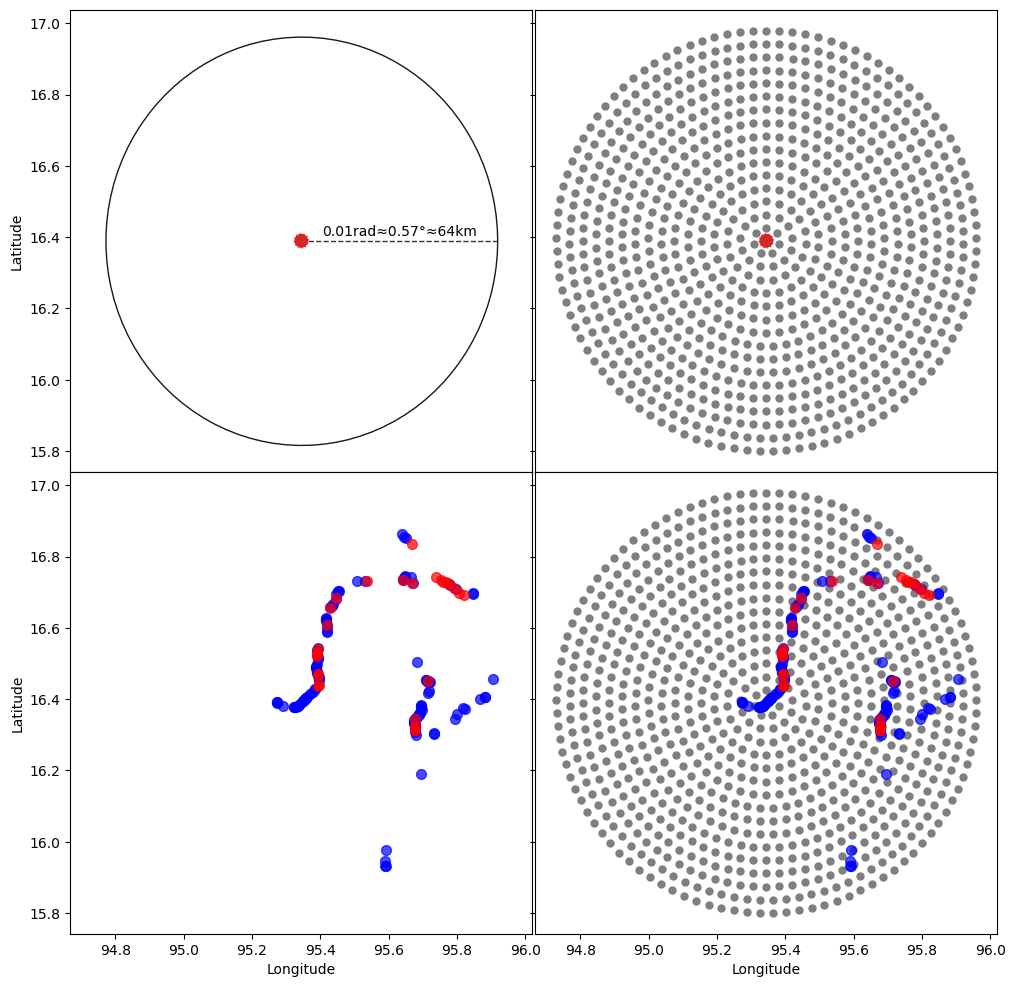

In [471]:
import random 

draw_scenario(
    data=data,
    centeridx=random.randrange(len(data['coords'])),
    partitioner=partitioner,
    radius=0.01,
    type='full'
    )

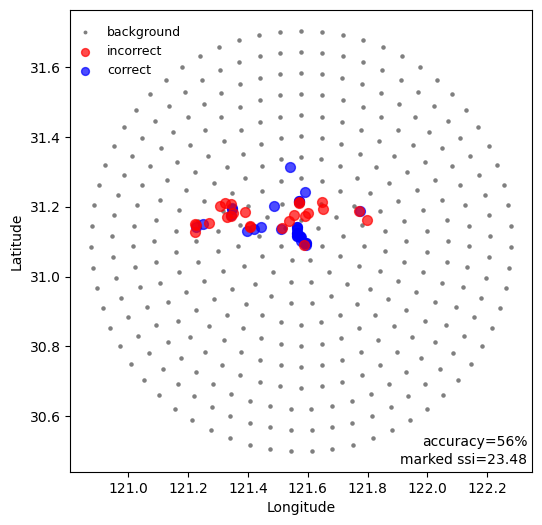

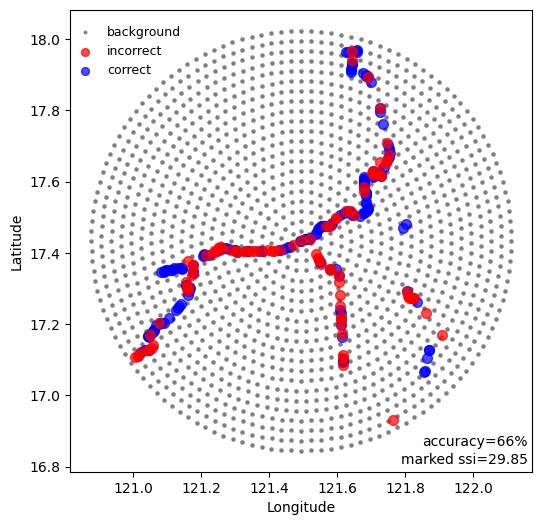

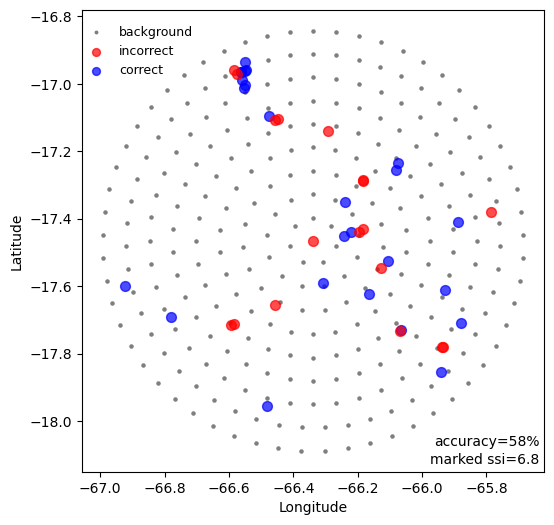

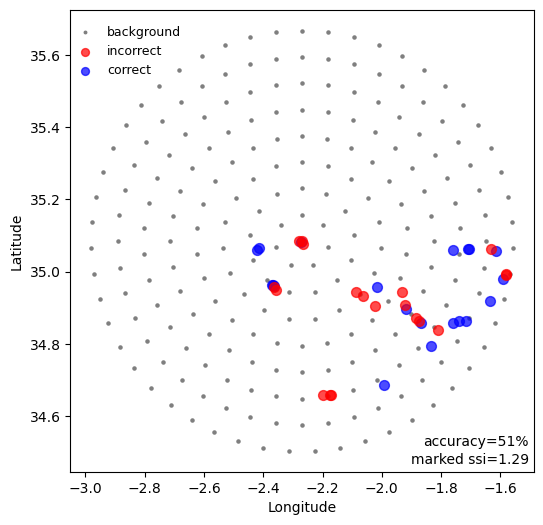

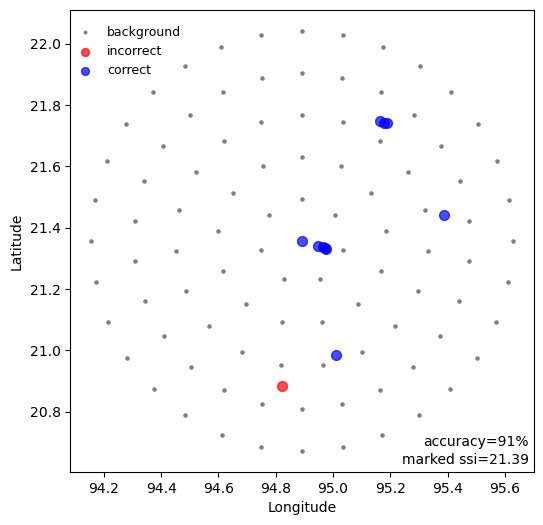

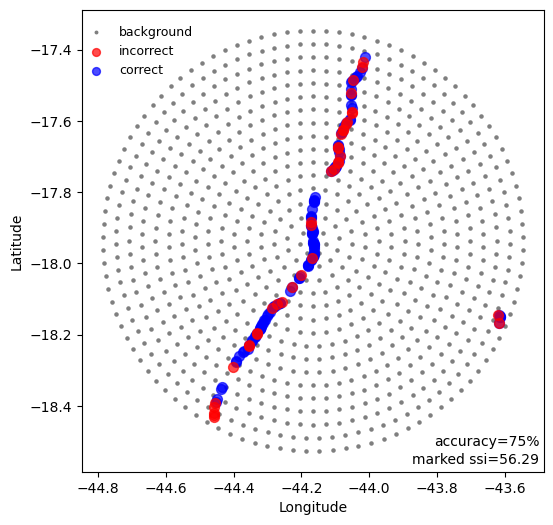

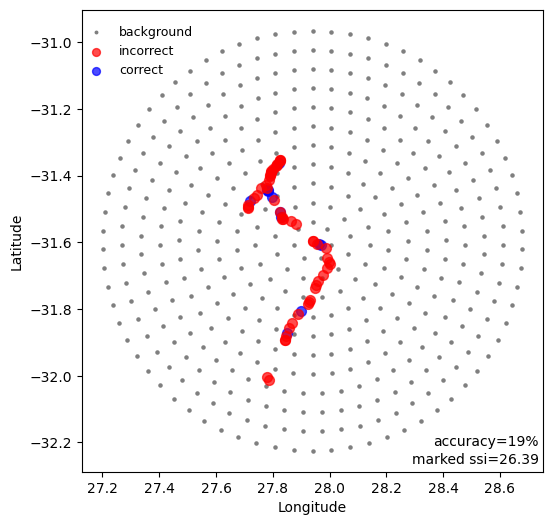

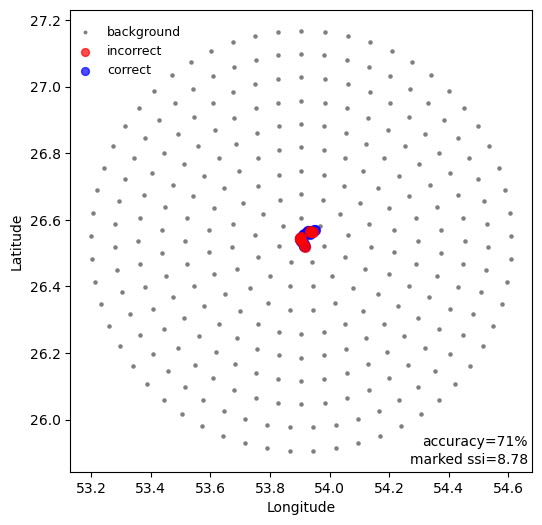

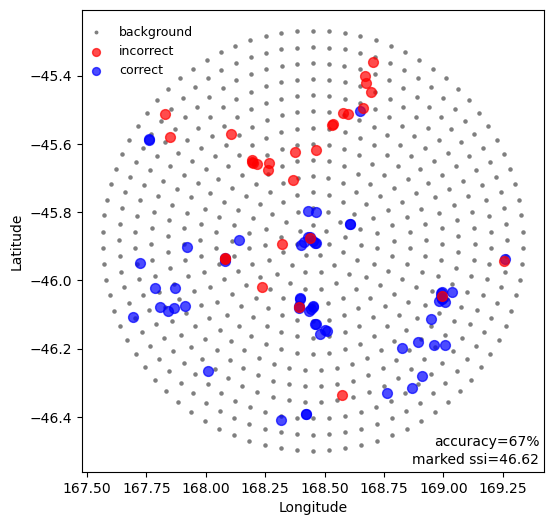

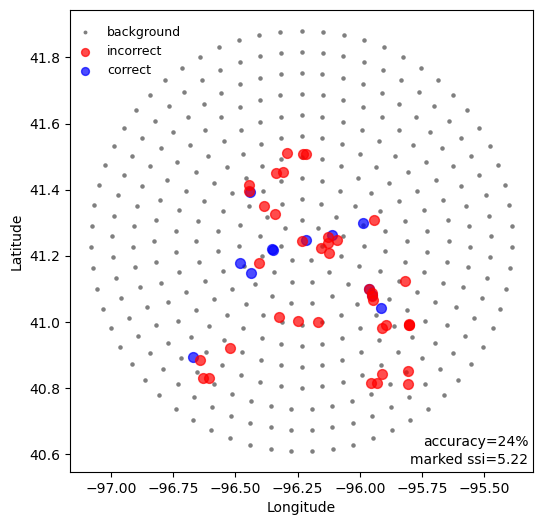

In [472]:
import random

for i in range(10):
    a = draw_scenario(data=data, centeridx=random.randrange(len(data['coords'])), partitioner=partitioner, radius=0.01, type='single')

In [ ]:
# partitioner.kdt.query(partitioner.coords, k=100, return_distance=True)
idx=8
radius = 0.01
min_dist=0.0
print(partitioner.get_neighborhood(idx, radius))
print(partitioner.nbrs[idx, (partitioner.dists[idx] >= min_dist) & (partitioner.dists[idx] <= radius)])
mask = partitioner.nbrs[idx, (partitioner.dists[idx] >= min_dist) & (partitioner.dists[idx] <= radius)]
mask.nonzero()

i = 8
center = coords[i]
print(center)
presence_ids = partitioner.get_neighborhood(i, 0.01)
print(presence_ids)
presence_points = coords[presence_ids]
print(presence_points)
presence_values = values[presence_ids]
print(presence_values)

[     8 160636 104750  71481 172729  77885 175155  89524  79110  75239
  16383 132975 140660  97264  14512  75410 123569  47699  91237  48665
 158708 191954  89071 124827 131420  60860 188319 142401 141639 183641
 125150  90552 139335 132985  81430 147564 161529 105237 178876  95461
 201208  14064 109614 186985 116194  24370 190322  95155 147369 201266
  97570  21662 133164 107250 167756   9864  11617]
[     8 160636 104750  71481 172729  77885 175155  89524  79110  75239
  16383 132975 140660  97264  14512  75410 123569  47699  91237  48665
 158708 191954  89071 124827 131420  60860 188319 142401 141639 183641
 125150  90552 139335 132985  81430 147564 161529 105237 178876  95461
 201208  14064 109614 186985 116194  24370 190322  95155 147369 201266
  97570  21662 133164 107250 167756   9864  11617]


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56]),)

In [ ]:

## The index of the center point to evaluate.

locs, accs, ssis = [], [], []

for idx in range(partitioner.N):
    center = coords[idx]

    ## Extract neighbood points.
    presence_idxs = partitioner.get_neighborhood(idx, radius)
    presence_points, presence_values = coords[presence_idxs], values[presence_idxs]

    avg_acc = np.mean(values[presence_idxs])

    ## Use automatic density estimation. Users can manually specify this hyperparameter.

    ## pnp_ssi is the former base geo-bias
    unmarked_ssi = compute_unmarked_ssi(presence_points, center, radius, density="auto", k=4)
    ## rp_ssi is the former relative geo-bias
    marked_ssi = compute_marked_ssi(presence_points, presence_values, center, radius, density="auto", k=4)

    locs.append(center)
    accs.append(avg_acc)
    ssis.append(marked_ssi)

    # print("Unmarked SSI Score: ", unmarked_ssi, "Marked SSI Score: ", marked_ssi)
    # print("Processed: ", idx, "Marked SSI Score: ", marked_ssi)

    print("Processed: {}\r".format(idx), end="")

np.savez("results/{}_scale_{}_radius".format(scale, radius), locs=locs, accs=accs, ssis=ssis)


/home/imajic/pcloud/01_Projects/02_papers/2025_zhangyu_geobias_tools_GIScience/PyGBS/gbs/ssi/surprisal.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  Mu_corrected += beta1 * self.mean_coef_dict[k] * self.mean_dict[k] / beta2
/home/imajic/pcloud/01_Projects/02_papers/2025_zhangyu_geobias_tools_GIScience/PyGBS/gbs/ssi/surprisal.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  Mu_corrected += beta1 * self.mean_coef_dict[k] * self.mean_dict[k] / beta2


/home/imajic/pcloud/01_Projects/02_papers/2025_zhangyu_geobias_tools_GIScience/PyGBS/gbs/ssi/surprisal.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  Mu_corrected += beta1 * self.mean_coef_dict[k] * self.mean_dict[k] / beta2


/home/imajic/pcloud/01_Projects/02_papers/2025_zhangyu_geobias_tools_GIScience/PyGBS/gbs/ssi/surprisal.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  Mu_corrected += beta1 * self.mean_coef_dict[k] * self.mean_dict[k] / beta2


KeyboardInterrupt: 